# LR Analysis

This notebook analyze the LR properties of a system starting from the coupling matrix, transition quantities and the energies of the virtual orbitals

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import DoS as D
from futile import Yaml
from futile.Utils import write
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import LRTDDFT as LR
HaeV=27.21138386

Autosave disabled


In [2]:
%matplotlib inline

In [3]:
def build_syst_dict(systPath,norb):
    syst = {}
    outp = systPath+'linear-response/log'
    %cd $outp
    logs = !ls log-Rmult_*
    for l in logs:
        data = lf.Logfile(l)
        rmult = data.log['dft']['rmult'][0]
        nvirt = len(data.evals[0][0]) - norb
        syst[rmult] = {'nvirt':nvirt}
    %cd ../../../../
    return syst
    
def get_tddft_quantities(syst,sysPath):
    from futile.Utils import write
    outp = sysPath+'linear-response/log'
    %cd $outp
    for rVal in syst:
        dpath = 'data-'+'Rmult_'+str(rVal)+'/transition_quantities.txt'
        trans = np.loadtxt(dpath)
        syst[rVal]['T']=trans
        cpath = 'data-'+'Rmult_'+str(rVal)+'/coupling_matrix.txt'
        Cmat = np.loadtxt(cpath)
        syst[rVal]['C']=Cmat
        write('Casida Matrix is symmetric',np.allclose(Cmat,Cmat.T,atol=1.e-12))
        syst[rVal]['logfile'] = lf.Logfile('log-Rmult_'+str(rVal)+'_numVirt_'+str(syst[rVal]['nvirt'])+'.yaml')
    %cd ../../../../

## Analysis of $N_2$

In [136]:
norbN2 = 5
pathN2 = 'N2/free-bc/'
N2 = build_syst_dict(pathN2, norbN2)
naSmall = [16,64,96,160]
N2

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/free-bc/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


{7.0: {'nvirt': 280}, 9.0: {'nvirt': 280}, 10.0: {'nvirt': 280}}

In [137]:
reload(LR)
get_tddft_quantities(N2,pathN2)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/free-bc/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


Chose the value of nalpha that give the same maximum energy in all the box

In [138]:
nalphaEmax = {}
rVals = N2.keys()
rVals.sort()
eMax = N2[rVals[-1]]['logfile'].evals[0][0][-1]
nalphaEmax[rVals[-1]] = len(N2[rVals[-1]]['logfile'].evals[0][0])-norbN2
print 'max sampled energy = ', HaeV*eMax
for r in rVals[0:len(rVals)-1][::-1]:
    na = 0
    em = 0
    while(em<eMax):
        na+=1
        em= N2[r]['logfile'].evals[0][0][norbN2+na]
    nalphaEmax[r] = na
nalphaEmax

max sampled energy =  19.1972389886


{7.0: 101, 9.0: 214, 10.0: 280}

In [139]:
# Activate this if the result for the highest number of nalpha is needed
#nalphaEmax = {7.0:280,9.0:280,10.0:280}
nalphaEmax

{7.0: 101, 9.0: 214, 10.0: 280}

In [140]:
reload(LR)
LR.diagonalize_CM(norbN2,N2,naSmall,nalphaEmax)
LR.collect_LR(N2)

Solve for rVal =  9.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 214
Solve for rVal =  10.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 280
Solve for rVal =  7.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 101


### Statical polarizability

Plot the convergence of the statical polarizability in the various box

In [141]:
N2_alpha_ref = {'alphaX':10.868,'alphaY':10.868,'alphaZ':15.735}

In [142]:
reload(LR)
alpha_N2 = LR.collect_Alpha(N2,norbN2)

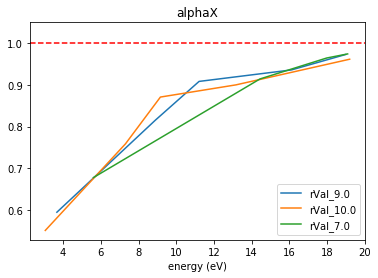

In [143]:
%matplotlib inline
component = 'alphaX'
for rVal in alpha_N2:
    val = np.array(alpha_N2[rVal][component])/N2_alpha_ref[component]
    plt.plot(alpha_N2[rVal]['naEnergy'],val,label='rVal_'+str(rVal))
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title(component)
plt.ylim(ymax=1.05)
plt.show()

### Dynamical polarizability

In [144]:
reload(LR)
N2_spectrum = LR.collect_spectrum(N2)

Compute for rVal =  9.0  with nalpha =  214
numpoint =  347  omegaMax (eV) =  47.2472820737
Compute for rVal =  10.0  with nalpha =  280
numpoint =  360  omegaMax (eV) =  49.0183956842
Compute for rVal =  7.0  with nalpha =  101
numpoint =  347  omegaMax (eV) =  47.3395059523


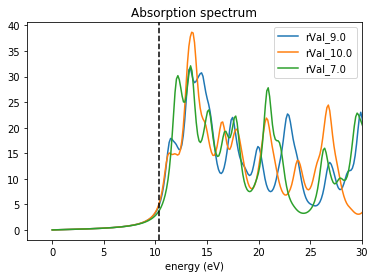

In [145]:
%matplotlib inline
syst = N2_spectrum
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=30)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(N2[7.0]['logfile'],norbN2,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

### Excitations

We attribute to the first numExc excitations a threshold key ('th') that contain the value of the psi_p of highest energy that contributes to the excitation, with a threshold level given by th_value. We take into account the degenaracy of the psi_p states to build the threshold levels.  

In [146]:
print HaeV*abs(LR.get_p_energy(N2[7.0]['logfile'],norbCO))
th_value = 1e-4
th_levels = [1,2,3,3,4]

[ 28.09660301  13.541359    11.74100622  11.74100599  10.39464082]


In [147]:
reload(LR)
numExc = 900
LR.collect_excitation_thr(N2,norbN2,numExc,th_levels,th_value)
N2_channels = LR.collect_channels(N2,norbN2,numExc,th_levels)

We plot the excitations landscape in the different box

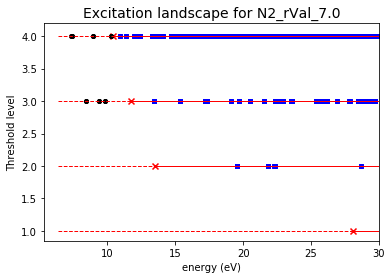

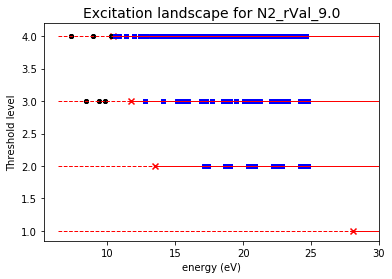

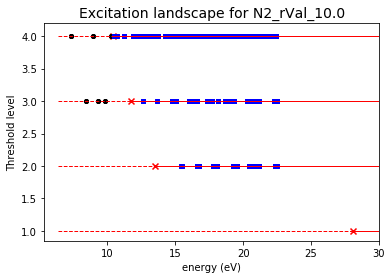

In [150]:
rVal = N2.keys()
rVal.sort()
for r in rVal:
    nalpha = N2[r]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    syst = N2[r]['eigenproblems'][nvirt]
    th_energies = HaeV*abs(LR.get_p_energy(N2[r]['logfile'],norbCO))

    Emin = HaeV*np.sqrt(syst['eigenvalues'][0])-1
    Emax = 30 #HaeV*np.sqrt(syst['eigenvalues'][numExc-1])

    for level in N2_channels[r]:
        eng_th = th_energies[th_levels.index(level)]
        plt.plot((Emin,eng_th),(level,level),'--',c='red',linewidth=1)
        plt.plot((eng_th,Emax),(level,level),'-',c='red',linewidth=1)
        plt.scatter(eng_th,level,marker='x',c='red')
  
        for exc in N2_channels[r][level]:
            if exc[1] < eng_th: 
                plt.scatter(exc[1],level,s=16,marker='o',c='black')
            else:
                plt.scatter(exc[1],level,s=14,marker='s',c='blue')
                
    plt.title('Excitation landscape for N2_rVal_'+str(r),size=14) 
    plt.xlabel('energy (eV)')
    plt.ylabel('Threshold level')
    plt.xlim(xmin=Emin-1,xmax=Emax)
    plt.show()

We identify the excitations below and above threshold

In [151]:
reload(LR)
N2_ind_bt,N2_ind_at = LR.collect_index_bt_at(N2)

Plot the Dos below threshold

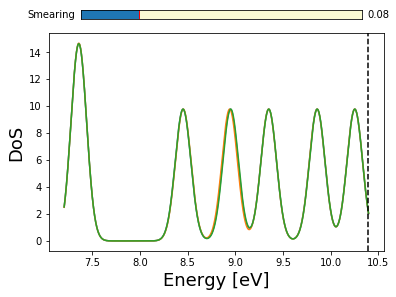

In [152]:
dos=D.DoS(fermi_level=10.39)
for rVal in N2:
    nalpha = N2[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(N2[rVal]['eigenproblems'][nvirt]['eigenvalues'][N2_ind_bt[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.003*HaeV)

Plot the complete Dos

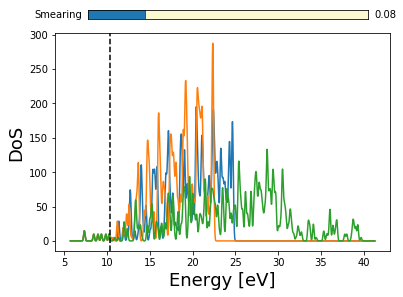

In [153]:
dos=D.DoS(fermi_level=10.39)
for rVal in N2:
    nalpha = N2[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(N2[rVal]['eigenproblems'][nvirt]['eigenvalues'][N2_ind_bt[rVal]+N2_ind_at[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.003*HaeV)

We plot the dos of each channel comparing the results of different box

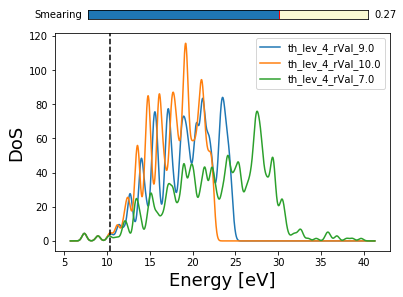

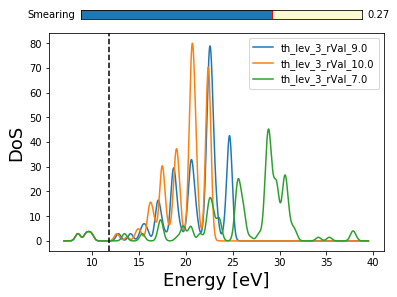

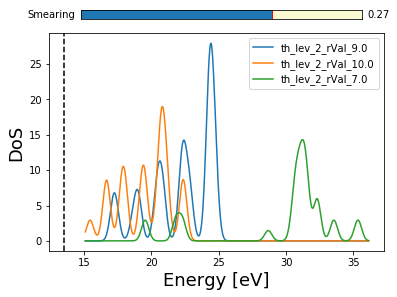

In [154]:
%matplotlib inline
levels = [4,3,2]
for l in levels:
    fe = HaeV*abs(LR.get_p_energy(N2[7.0]['logfile'],norbN2)[th_levels.index(l)])
    dos=D.DoS(fermi_level=fe)
    for rVal in N2_channels:
        eng = []
        for exc in N2_channels[rVal][l]:
            eng.append(exc[1])
        dos.append(energies=np.array([eng]),label='th_lev_'+str(l)+'_rVal_'+str(rVal))
    dos.plot(sigma=0.01*HaeV)

We repeat the calculation of dynamical polarizability separing the contributions due to excitations above and below threshold 

In [155]:
reload(LR)
N2_spectrum_bt,N2_spectrum_at = LR.collect_spectrum_bt_at(N2,N2_ind_bt,N2_ind_at)

numpoint =  181  omegaMax (eV) =  24.7563791887
numpoint =  181  omegaMax (eV) =  24.7563791887
numpoint =  165  omegaMax (eV) =  22.4781040339
numpoint =  165  omegaMax (eV) =  22.4781040339
numpoint =  291  omegaMax (eV) =  39.684195984
numpoint =  291  omegaMax (eV) =  39.684195984


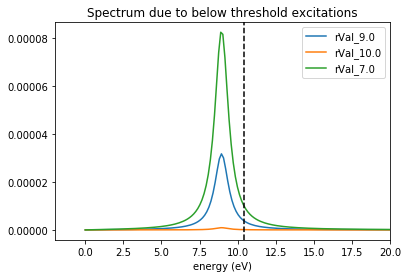

In [156]:
%matplotlib inline
syst = N2_spectrum_bt
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Spectrum due to below threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(N2[7.0]['logfile'],norbN2,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

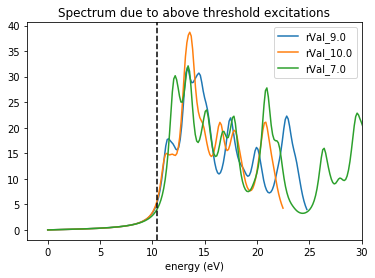

In [157]:
%matplotlib inline
syst = N2_spectrum_at
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=30)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Spectrum due to above threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(N2[7.0]['logfile'],norbN2,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

## Analysis of $CO$

In [4]:
norbCO = 5
pathCO = 'CO/free-bc/'
CO = build_syst_dict(pathCO, norbCO)
naSmall = [16,64,96,160]
CO

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


{7.0: {'nvirt': 280}, 9.0: {'nvirt': 280}, 10.0: {'nvirt': 280}}

In [5]:
reload(LR)
get_tddft_quantities(CO,pathCO)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


Chose the value of nalpha that give the same maximum energy in all the box

In [6]:
nalphaEmax = {}
rVals = CO.keys()
rVals.sort()
eMax = CO[rVals[-1]]['logfile'].evals[0][0][-1]
nalphaEmax[rVals[-1]] = len(CO[rVals[-1]]['logfile'].evals[0][0])-norbCO
print 'max sampled energy = ', HaeV*eMax
for r in rVals[0:len(rVals)-1][::-1]:
    na = 0
    em = 0
    while(em<eMax):
        na+=1
        em= CO[r]['logfile'].evals[0][0][norbCO+na]
    nalphaEmax[r] = na
nalphaEmax

max sampled energy =  14.7769179033


{7.0: 98, 9.0: 185, 10.0: 280}

In [7]:
# Activate this if the result for the highest number of nalpha is needed
nalphaEmax = {7.0:280,9.0:280,10.0:280}
nalphaEmax

{7.0: 280, 9.0: 280, 10.0: 280}

In [8]:
reload(LR)
LR.diagonalize_CM(norbCO,CO,naSmall,nalphaEmax)
LR.collect_LR(CO)

Solve for rVal =  9.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 280
Solve for rVal =  10.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 280
Solve for rVal =  7.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 280


### Statical polarizability

Plot the convergence of the statical polarizability in the various box

In [9]:
CO_alpha_ref = {'alphaX':13.235,'alphaY':13.235,'alphaZ':18.728}

In [10]:
reload(LR)
alpha_CO = LR.collect_Alpha(CO,norbCO)

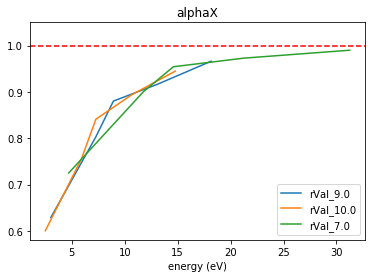

In [11]:
%matplotlib inline
component = 'alphaX'
for rVal in alpha_CO:
    val = np.array(alpha_CO[rVal][component])/CO_alpha_ref[component]
    plt.plot(alpha_CO[rVal]['naEnergy'],val,label='rVal_'+str(rVal))
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title(component)
plt.ylim(ymax=1.05)
plt.show()

### Dynamical polarizability

In [12]:
reload(LR)
CO_spectrum = LR.collect_spectrum(CO)

Compute for rVal =  9.0  with nalpha =  280
numpoint =  336  omegaMax (eV) =  45.8183849825
Compute for rVal =  10.0  with nalpha =  280
numpoint =  311  omegaMax (eV) =  42.431982253
Compute for rVal =  7.0  with nalpha =  280
numpoint =  434  omegaMax (eV) =  59.1066901023


9.366395583


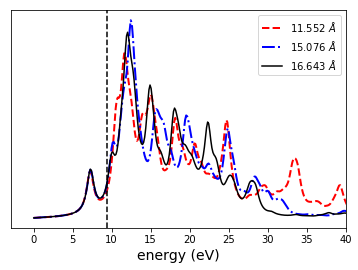

In [17]:
# use gtk or auto to display on file
%matplotlib inline
syst = CO_spectrum
part = 'imagPart'
size = str(CO[7.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[7.0]['omega'],syst[7.0][part],'--',c='red',linewidth=2,label= size + ' $\AA$')
size = str(CO[9.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[9.0]['omega'],syst[9.0][part],'-.',c='blue',linewidth=2,label= size + ' $\AA$')
size = str(CO[10.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[10.0]['omega'],syst[10.0][part],'-',c='black',linewidth=1.5,label= size + ' $\AA$')
plt.xlim(xmax=40)
plt.yticks([])
plt.xlabel('energy (eV)',size = 14)
#plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
print eps_h
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.legend(loc='best')
plt.show()

Write spectrum on file

In [56]:
%cd 'DataForPlot'
box = CO_spectrum.keys()
box.sort()
box
for b in box:
    fname = 'CO_spectrum_rmult'+str(b)+'.txt'
    print fname
    f = open(fname,'w')
    for ind,o in enumerate(CO_spectrum[b]['omega']):
        s = str(o)+'\t'+str(CO_spectrum[b]['imagPart'][ind])+'\n'
        f.write(s)
    f.close()
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/DataForPlot
CO_spectrum_rmult7.0.txt
CO_spectrum_rmult9.0.txt
CO_spectrum_rmult10.0.txt
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


### Excitations

We attribute to the first numExc excitations a threshold key ('th') that contain the value of the psi_p of highest energy that contributes to the excitation, with a threshold level given by th_value. We take into account the degenaracy of the psi_p states to build the threshold levels.  

In [18]:
print HaeV*abs(LR.get_p_energy(CO[7.0]['logfile'],norbCO))
th_value = 1e-4
th_levels = [1,2,3,3,4]

[ 27.65494303  14.24083585  11.117007    11.11700672   9.36639558]


In [19]:
reload(LR)
numExc = 2800
LR.collect_excitation_thr(CO,norbCO,numExc,th_levels,th_value)
CO_channels = LR.collect_channels(CO,norbCO,numExc,th_levels)

We plot the excitations landscape in the different box

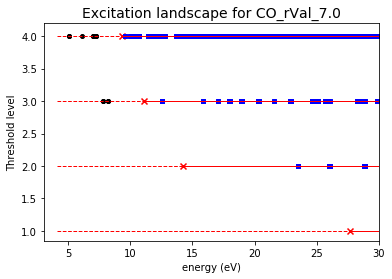

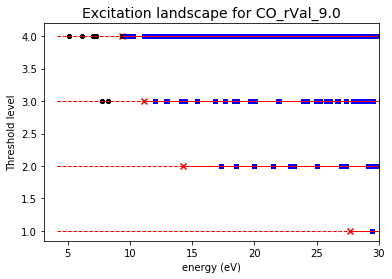

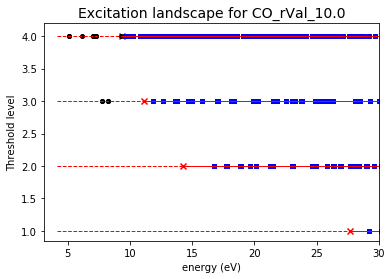

In [45]:
%matplotlib inline
rVal = CO.keys()
rVal.sort()
for r in rVal:
    nalpha = CO[r]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    syst = CO[r]['eigenproblems'][nvirt]
    th_energies = HaeV*abs(LR.get_p_energy(CO[r]['logfile'],norbCO))

    Emin = HaeV*np.sqrt(syst['eigenvalues'][0])-1
    Emax = 30 #HaeV*np.sqrt(syst['eigenvalues'][numExc-1])

    for level in CO_channels[r]:
        eng_th = th_energies[th_levels.index(level)]
        plt.plot((Emin,eng_th),(level,level),'--',c='red',linewidth=1)
        plt.plot((eng_th,Emax),(level,level),'-',c='red',linewidth=1)
        plt.scatter(eng_th,level,marker='x',c='red')
  
        for exc in CO_channels[r][level]:
            if exc[1] < eng_th: 
                plt.scatter(exc[1],level,s=16,marker='o',c='black')
            else:
                plt.scatter(exc[1],level,s=14,marker='s',c='blue')
                
    plt.title('Excitation landscape for CO_rVal_'+str(r),size=14) 
    plt.xlabel('energy (eV)')
    plt.ylabel('Threshold level')
    plt.xlim(xmin=Emin-1,xmax=Emax)
    plt.show()

We identify the excitations below and above threshold

In [20]:
reload(LR)
CO_ind_bt,CO_ind_at = LR.collect_index_bt_at(CO)

Plot the Dos below threshold

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


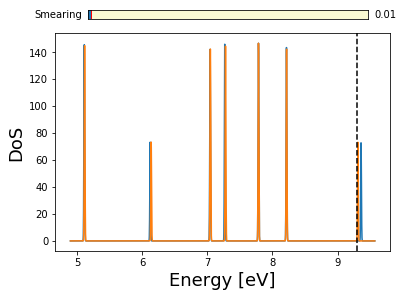

In [21]:
%matplotlib inline
dos=D.DoS(fermi_level=9.3)
for rVal in [9.0,10.0]: #CO:
    nalpha = CO[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(CO[rVal]['eigenproblems'][nvirt]['eigenvalues'][CO_ind_bt[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
#dos.plot(sigma=0.003*HaeV)
dos.plot(sigma=0.0002*HaeV)

Plot the complete Dos

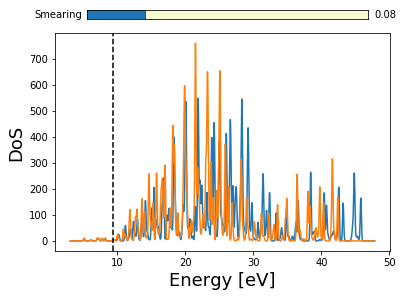

In [22]:
%matplotlib inline
dos=D.DoS(fermi_level=9.3)
for rVal in [9.0,10.0]: #CO:
    nalpha = CO[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(CO[rVal]['eigenproblems'][nvirt]['eigenvalues'][CO_ind_bt[rVal]+CO_ind_at[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.003*HaeV)

Write dos data on file

In [55]:
%cd 'DataForPlot'

# Dos below threshold
sigma=0.0002*HaeV
for rVal in [9.0,10.0]:
    dos=D.DoS(fermi_level=9.3)
    nvirt = 280   
    eng = HaeV*np.sqrt(CO[rVal]['eigenproblems'][nvirt]['eigenvalues'][CO_ind_bt[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
    fname = 'CO_dos_bt_rmult'+str(rVal)+'.txt'
    LR.write_dos(dos,fname,sigma)

# Complete Dos
sigma=0.003*HaeV
for rVal in [9.0,10.0]:
    dos=D.DoS(fermi_level=9.3)
    nvirt = 280   
    eng = HaeV*np.sqrt(CO[rVal]['eigenproblems'][nvirt]['eigenvalues'][CO_ind_bt[rVal]+CO_ind_at[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
    fname = 'CO_dos_bt+at_rmult'+str(rVal)+'.txt'
    LR.write_dos(dos,fname,sigma)

%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/DataForPlot
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


We plot the dos of each channel comparing the results of different box

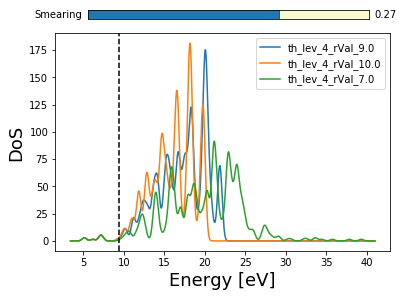

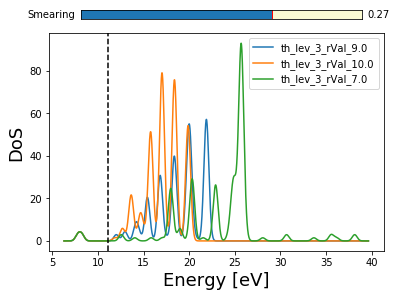

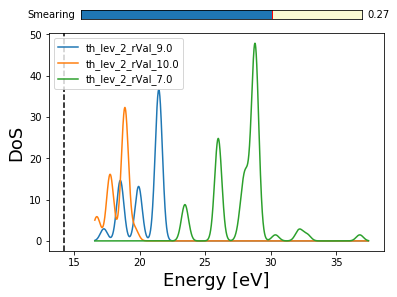

In [113]:
%matplotlib inline
levels = [4,3,2]
for l in levels:
    fe = HaeV*abs(LR.get_p_energy(CO[7.0]['logfile'],norbCO)[th_levels.index(l)])
    dos=D.DoS(fermi_level=fe)
    for rVal in CO_channels:
        eng = []
        for exc in CO_channels[rVal][l]:
            eng.append(exc[1])
        dos.append(energies=np.array([eng]),label='th_lev_'+str(l)+'_rVal_'+str(rVal))
    dos.plot(sigma=0.01*HaeV)

We repeat the calculation of dynamical polarizability separing the contributions due to excitations above and below threshold 

In [122]:
reload(LR)
CO_spectrum_bt,CO_spectrum_at = LR.collect_spectrum_bt_at(CO,CO_ind_bt,CO_ind_at)

numpoint =  160  omegaMax (eV) =  21.8861126193
numpoint =  160  omegaMax (eV) =  21.8861126193
numpoint =  146  omegaMax (eV) =  19.8924830183
numpoint =  146  omegaMax (eV) =  19.8924830183
numpoint =  289  omegaMax (eV) =  39.3968120121
numpoint =  289  omegaMax (eV) =  39.3968120121


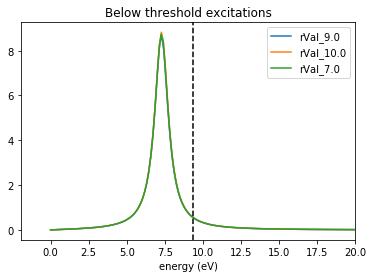

In [123]:
%matplotlib inline
syst = CO_spectrum_bt
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Spectrum due to below threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

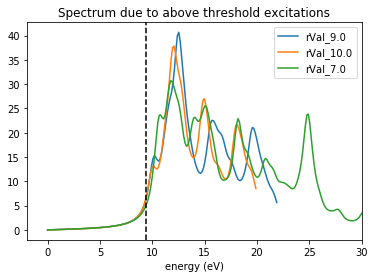

In [124]:
%matplotlib inline
syst = CO_spectrum_at
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=30)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Spectrum due to above threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

Convergence of the statical polarizability in function of the number of excitations

In [23]:
th_value = 1e-4
th_levels = [1,2,3,3,4]
reload(LR)
numExc = 2800
LR.collect_excitation_thr(CO,norbCO,numExc,th_levels,th_value)
CO_channels = LR.collect_channels(CO,norbCO,numExc,th_levels)
CO_ind_bt,CO_ind_at = LR.collect_index_bt_at(CO)

In [24]:
CO_ind_bt

{7.0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 9.0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 10.0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}

In [31]:
rVal = 7.0
print CO[rVal]['eigenproblems'][280]['alpha_xyz']
e2 = CO[rVal]['eigenproblems'][280]['eigenvalues']
f = CO[rVal]['eigenproblems'][280]['oscillator_strengths']
alp = LR.static_polarizabilities(e2,f)
print alp

[ 13.10074947  13.10074947  18.15669473]
[ 13.10074947  13.10074947  18.15669473]


In [32]:
ist = []
for exc in range(numExc):
    ist.append(2.0*f[exc][2]/e2[exc])

intIst = [0.0 for i in range(numExc)]

In [33]:
for ind,val in enumerate(ist):
    if ind > 0:
        intIst[ind] = intIst[ind-1]+val

In [34]:
e = HaeV*np.sqrt(e2)

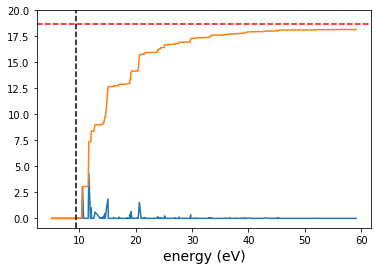

In [35]:
%matplotlib inline
plt.plot(e,1.0*np.array(ist))
plt.plot(e,np.array(intIst))
plt.axhline(y=CO_alpha_ref['alphaZ'], color='r', linestyle='--')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[rVal]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.xlabel('energy (eV)',size = 14)
#plt.xlim(xmin=5,xmax=61)
plt.ylim(ymax=20)
#plt.ylim(ymax=15)
plt.show()

In [37]:
intIst[10]

3.3625702796725706e-08

Save data on file

In [40]:
for ind,exc in enumerate(e):
    print exc, ist[ind], intIst[ind]

5.09541871994 4.79189063671e-33 0.0
5.09546540246 8.37817297327e-31 8.37817297327e-31
6.09409641952 1.02118839803e-30 1.85900569536e-30
7.03225454213 2.05810212509e-32 1.87958671661e-30
7.03497654146 1.03208459465e-28 1.05088046181e-28
7.23630116538 3.26715884337e-08 3.26715884337e-08
7.23636304486 2.42949266187e-26 3.26715884337e-08
7.78521043308 2.90633937917e-29 3.26715884337e-08
7.78521043318 2.43533421013e-27 3.26715884337e-08
8.20974119105 9.31701438187e-27 3.26715884337e-08
8.21197632152 9.54114363059e-10 3.36257027967e-08
9.60786995485 2.80315734054e-29 3.36257027967e-08
10.0102574861 0.0463617894137 0.0463618230394
10.1946413286 2.26421447609e-27 0.0463618230394
10.1947021174 6.25778165382e-31 0.0463618230394
10.4392028351 1.03448557608e-26 0.0463618230394
10.5439483889 3.0133864994 3.05974832244
10.7291121736 1.37270832265e-31 3.05974832244
10.7292024115 3.7246902245e-28 3.05974832244
10.7402444475 9.94881439461e-25 3.05974832244
10.740478673 0.00144783149326 3.06119615394
11

20.2723088588 9.90046103495e-28 14.2006715839
20.2750636149 4.5939098995e-29 14.2006715839
20.2755786213 4.60247206636e-30 14.2006715839
20.2861309221 6.34814202336e-30 14.2006715839
20.2861358299 1.68037105212e-29 14.2006715839
20.2867578306 4.93089571226e-06 14.2006765148
20.2871138807 1.4866856095e-27 14.2006765148
20.2883272035 4.84138805933e-05 14.2007249286
20.2892280876 1.62672599536e-27 14.2007249286
20.2914318196 2.87521378305e-06 14.2007278039
20.2939904408 2.6719505497e-29 14.2007278039
20.2940278644 2.89833144987e-30 14.2007278039
20.2954522673 9.64027227196e-28 14.2007278039
20.3035784854 2.89168710815e-29 14.2007278039
20.3036151629 1.2960227169e-29 14.2007278039
20.3080129479 3.86713199578e-30 14.2007278039
20.3082836424 7.67892210897e-29 14.2007278039
20.308476121 4.08871098806e-29 14.2007278039
20.3086921979 7.36336388819e-29 14.2007278039
20.3091109677 3.20974385846e-27 14.2007278039
20.3091517396 1.50875330713e-07 14.2007279547
20.321218931 1.20667829493e-29 14.20072

28.4088116432 1.93887841785e-28 16.9446997552
28.418297621 3.6453806279e-33 16.9446997552
28.420133743 1.65797501159e-28 16.9446997552
28.4315954704 1.92566270896e-31 16.9446997552
28.4320114446 1.29676206215e-30 16.9446997552
28.4389914802 2.55334539908e-29 16.9446997552
28.4398646367 1.05194731524e-30 16.9446997552
28.4480950659 2.17670691994e-30 16.9446997552
28.448962256 4.97204056538e-30 16.9446997552
28.4793463016 2.04552484978e-28 16.9446997552
28.4797314165 6.64562480691e-06 16.9447064008
28.5024822316 6.86933547712e-06 16.9447132701
28.5042005344 5.96850548842e-31 16.9447132701
28.5179322014 1.50200724796e-28 16.9447132701
28.518644995 1.03822485854e-08 16.9447132805
28.5243505639 4.58829325161e-28 16.9447132805
28.5368402999 0.00371589287058 16.9484291734
28.5428806475 9.04309606582e-30 16.9484291734
28.5437541198 1.68748082459e-31 16.9484291734
28.5438533028 8.46834347313e-30 16.9484291734
28.5452520336 6.62813956569e-30 16.9484291734
28.5821760507 1.56563527704e-29 16.94842

33.8781574217 1.22765499804e-30 17.6106822691
33.8949179743 0.00328868067747 17.6139709498
33.9195041666 5.57809772492e-24 17.6139709498
33.9537279729 1.43549886659e-05 17.6139853048
33.9552842074 1.82069309301e-26 17.6139853048
34.0002952422 1.65150929587e-29 17.6139853048
34.0008647624 2.92010454101e-27 17.6139853048
34.0010790029 6.74111385858e-30 17.6139853048
34.0015256304 4.26469667111e-30 17.6139853048
34.0018886658 6.07233725637e-30 17.6139853048
34.0022392451 1.46146263438e-06 17.6139867662
34.1106521241 1.7991605008e-06 17.6139885654
34.1107055117 4.57851300071e-27 17.6139885654
34.162360361 1.612466788e-26 17.6139885654
34.1623708961 4.50310556969e-07 17.6139890157
34.1624404367 9.81478355976e-27 17.6139890157
34.1624992169 4.80935998365e-29 17.6139890157
34.2087703759 6.01671019948e-33 17.6139890157
34.2088694225 2.43065895352e-34 17.6139890157
34.3410595479 0.00183596988057 17.6158249856
34.3487015466 1.56889070054e-28 17.6158249856
34.3625334627 1.7902827807e-29 17.615824

39.3698898621 6.17964426691e-28 17.8824828386
39.371270987 4.79261780614e-29 17.8824828386
39.3712754529 1.25790934514e-28 17.8824828386
39.3713027318 6.2018528379e-28 17.8824828386
39.37130302 2.12158557506e-28 17.8824828386
39.3753082639 3.54562352878e-29 17.8824828386
39.3753093426 2.6197612718e-30 17.8824828386
39.3768814628 9.779621208e-25 17.8824828386
39.3769342802 1.685097111e-05 17.8824996896
39.3792464794 1.74385762405e-26 17.8824996896
39.3800410369 1.23331735382e-26 17.8824996896
39.3814918784 0.00168136358759 17.8841810532
39.3815917611 1.33588905687e-05 17.884194412
39.3825985967 2.9690359722e-05 17.8842241024
39.382656073 2.52569831132e-25 17.8842241024
39.3842581765 5.42821204248e-27 17.8842241024
39.3844231684 7.59754161281e-28 17.8842241024
39.3866676551 1.3689145701e-28 17.8842241024
39.3866683297 3.00520710433e-29 17.8842241024
39.3869460791 2.67455716504e-24 17.8842241024
39.3869541939 5.59471860594e-07 17.8842246619
39.3888560241 3.02525473456e-28 17.8842246619
39

In [47]:
%cd 'DataForPlot'
fname = 'CO_alphazzVsExcEnergy_rmult7.0.txt'
f = open(fname,'w')
f.write('exc energy \t alphazz istogram \t integrated istogram \n')
for ind,exc in enumerate(e):
    s = str(exc)+'\t'+str(ist[ind])+'\t'+str(intIst[ind])+'\n'
    f.write(s)
f.close()
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/DataForPlot
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


## Analysis of $C_6H_6$

In [48]:
norbC6H6 = 15
pathC6H6 = 'C6H6/free-bc/'
C6H6 = build_syst_dict(pathC6H6, norbC6H6)
naSmall = [16,64,96,160]
C6H6

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


{7.0: {'nvirt': 220}, 9.0: {'nvirt': 220}, 10.0: {'nvirt': 220}}

In [49]:
reload(LR)
get_tddft_quantities(C6H6,pathC6H6)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


Chose the value of nalpha that give the same maximum energy in all the box

In [50]:
nalphaEmax = {}
rVals = C6H6.keys()
rVals.sort()
eMax = C6H6[rVals[-1]]['logfile'].evals[0][0][-1]
nalphaEmax[rVals[-1]] = len(C6H6[rVals[-1]]['logfile'].evals[0][0])-norbC6H6
print 'max sampled energy = ', HaeV*eMax
for r in rVals[0:len(rVals)-1][::-1]:
    na = 0
    em = 0
    while(em<eMax):
        na+=1
        em= C6H6[r]['logfile'].evals[0][0][norbC6H6+na]
    nalphaEmax[r] = na
    print 'em for ', r, ' = ', HaeV*em
nalphaEmax

max sampled energy =  9.71397014577
em for  9.0  =  9.84432534394
em for  7.0  =  9.74159044136


{7.0: 94, 9.0: 169, 10.0: 220}

In [51]:
# Activate this if the result for the highest number of nalpha is needed
nalphaEmax = {7.0:220,9.0:220,10.0:220}
nalphaEmax

{7.0: 220, 9.0: 220, 10.0: 220}

In [52]:
LR.diagonalize_CM(norbC6H6,C6H6,naSmall,nalphaEmax)
LR.collect_LR(C6H6)

Solve for rVal =  9.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 220
Solve for rVal =  10.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 220
Solve for rVal =  7.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 220


### Statical polarizability

Plot the convergence of the statical polarizability in the various box

In [53]:
C6H6_alpha_ref = {'alphaX':83.856,'alphaY':83.856,'alphaZ':45.62}

In [54]:
reload(LR)
alpha_C6H6 = LR.collect_Alpha(C6H6,norbC6H6)

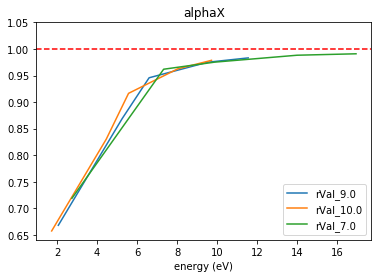

In [55]:
%matplotlib inline
component = 'alphaX'
for rVal in alpha_C6H6:
    val = np.array(alpha_C6H6[rVal][component])/C6H6_alpha_ref[component]
    plt.plot(alpha_C6H6[rVal]['naEnergy'],val,label='rVal_'+str(rVal))
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title(component)
plt.ylim(ymax=1.05)
plt.show()

### Dynamical polarizability

In [56]:
reload(LR)
C6H6_spectrum = LR.collect_spectrum(C6H6)

Compute for rVal =  9.0  with nalpha =  220
numpoint =  240  omegaMax (eV) =  32.740054836
Compute for rVal =  10.0  with nalpha =  220
numpoint =  228  omegaMax (eV) =  31.0830728297
Compute for rVal =  7.0  with nalpha =  220
numpoint =  280  omegaMax (eV) =  38.1274605755


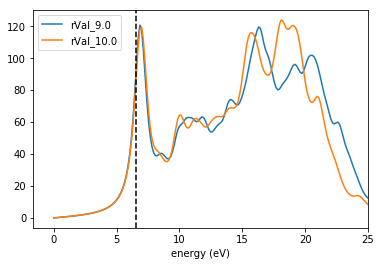

In [57]:
%matplotlib inline
syst = C6H6_spectrum
for rVal in [9.0,10.0]:#syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=25)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
#plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

### Excitations

We attribute to the first numExc excitations a threshold key ('th') that contain the value of the psi_p of highest energy that contributes to the excitation, with a threshold level given by th_value. We take into account the degenaracy of the psi_p states to build the threshold levels.  

In [58]:
print HaeV*abs(LR.get_p_energy(C6H6[10.0]['logfile'],norbC6H6))
th_value = 5e-2 # best result for 5e-2
th_levels = [1,2,2,3,3,4,5,5,6,6,7,8,8,9,9]

[ 21.15922984  18.36439554  18.36376565  14.82142626  14.82100924
  13.00017164  11.14572656  11.06283511  10.28699872  10.2864815
   9.24529617   8.28996563   8.288049     6.50839935   6.50820332]


In [59]:
reload(LR)
numExc = 1000
LR.collect_excitation_thr(C6H6,norbC6H6,numExc,th_levels,th_value)
C6H6_channels = LR.collect_channels(C6H6,norbC6H6,numExc,th_levels)

We plot the excitations landscape in the different box

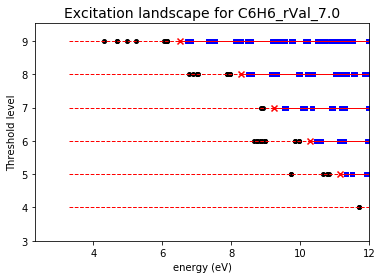

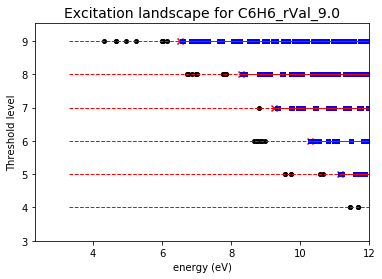

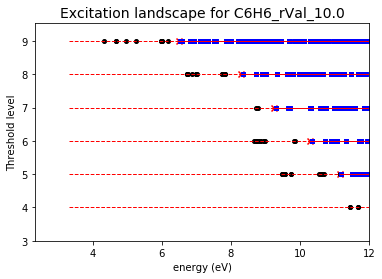

In [60]:
rVal = C6H6.keys()
rVal.sort()
for r in rVal:
    nalpha = C6H6[r]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    syst = C6H6[r]['eigenproblems'][nvirt]
    th_energies = HaeV*abs(LR.get_p_energy(C6H6[r]['logfile'],norbC6H6))

    Emin = HaeV*np.sqrt(syst['eigenvalues'][0])-1
    Emax = 12 #HaeV*np.sqrt(syst['eigenvalues'][numExc-1])

    for level in C6H6_channels[r]:
        eng_th = th_energies[th_levels.index(level)]
        plt.plot((Emin,eng_th),(level,level),'--',c='red',linewidth=1)
        plt.plot((eng_th,Emax),(level,level),'-',c='red',linewidth=1)
        plt.scatter(eng_th,level,marker='x',c='red')
  
        for exc in C6H6_channels[r][level]:
            if exc[1] < eng_th: 
                plt.scatter(exc[1],level,s=16,marker='o',c='black')
            else:
                plt.scatter(exc[1],level,s=14,marker='s',c='blue')
                
    plt.title('Excitation landscape for C6H6_rVal_'+str(r),size=14) 
    plt.xlabel('energy (eV)')
    plt.ylabel('Threshold level')
    plt.xlim(xmin=Emin-1,xmax=Emax)
    plt.ylim(ymin=3)
    plt.show()

In [96]:
%matplotlib gtk
r = 9.0
nalpha = C6H6[r]['eigenproblems'].keys()
nalpha.sort()
nvirt = nalpha[-1]
syst = C6H6[r]['eigenproblems'][nvirt]
th_energies = HaeV*abs(LR.get_p_energy(C6H6[r]['logfile'],norbC6H6))

Emin = HaeV*np.sqrt(syst['eigenvalues'][0])-1
Emax = 13.5 #HaeV*np.sqrt(syst['eigenvalues'][numExc-1])

for level in C6H6_channels[r]:
    eng_th = th_energies[th_levels.index(level)]
    plt.plot((Emin,eng_th),(level,level),'--',c='red',linewidth=1)
    plt.plot((eng_th,Emax),(level,level),'-',c='red',linewidth=1)
    plt.plot((eng_th,eng_th),(0,level),'--',c='black',linewidth=0.5)
    plt.scatter(eng_th,level,marker='x',c='red')
  
    for exc in C6H6_channels[r][level]:
        if exc[1] < eng_th: 
            plt.scatter(exc[1],level,s=16,marker='o',c='black')
        else:
            plt.scatter(exc[1],level,s=16,marker='o',facecolors='none',edgecolors='blue')   
            #plt.scatter(exc[1],level,s=14,marker='s',c='blue')
plt.xlabel('energy (eV)')
plt.ylabel('Threshold levels')
plt.xlim(xmin=Emin-0.2,xmax=Emax)
plt.ylim(ymin=3.2)
# remove number from yaxis label
ax = plt.axes()
ax.yaxis.set_major_formatter(plt.NullFormatter())
plt.show()

We identify the excitations below and above threshold

In [97]:
reload(LR)
C6H6_ind_bt,C6H6_ind_at = LR.collect_index_bt_at(C6H6)

Plot the Dos below threshold

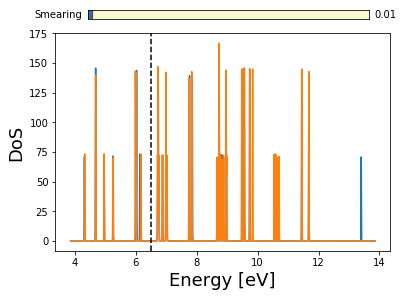

In [98]:
%matplotlib inline
dos=D.DoS(fermi_level=6.5)
for rVal in [9.0,10.0]: #C6H6:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][C6H6_ind_bt[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
#dos.plot(sigma=0.001*HaeV)
dos.plot(sigma=0.0002*HaeV)

Plot the dos above threshold

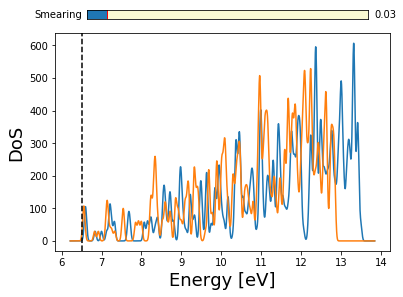

In [99]:
dos=D.DoS(fermi_level=6.5)
for rVal in [9.0,10.0]: #C6H6:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][C6H6_ind_at[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.001*HaeV)

Plot the complete dos

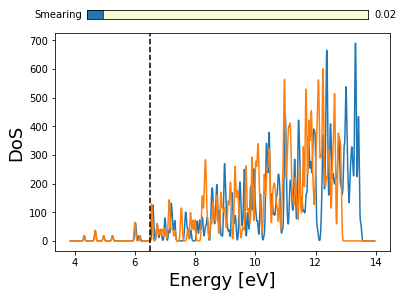

In [101]:
%matplotlib inline
dos=D.DoS(fermi_level=6.5)
for rVal in [9.0,10.0]: #C6H6:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][C6H6_ind_bt[rVal]+C6H6_ind_at[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
#dos.plot(sigma=0.001*HaeV)
dos.plot(sigma=0.0008*HaeV)

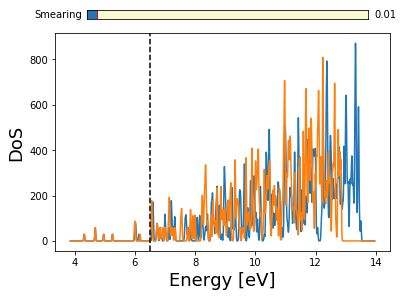

In [107]:
# use gtk to display on file
%matplotlib inline
dos=D.DoS(fermi_level=6.5)
for rVal in [9.0,10.0]: #C6H6:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][C6H6_ind_bt[rVal]+C6H6_ind_at[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.0005*HaeV)

In [124]:
C6H6[10.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2]

16.722

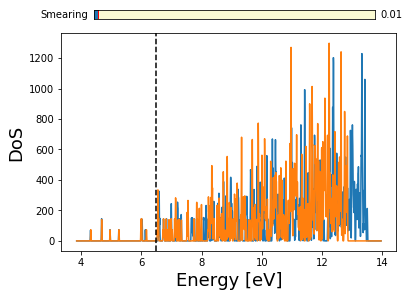

In [102]:
%matplotlib inline
dos=D.DoS(fermi_level=6.5)
for rVal in [9.0,10.0]: #C6H6:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][C6H6_ind_bt[rVal]+C6H6_ind_at[rVal]])
    dos.append(energies=np.array([eng]),label= '_rVal_')
dos.plot(sigma=0.0002*HaeV)

Write dos data on file

In [116]:
%cd 'DataForPlot'

# Dos below threshold
sigma=0.0002*HaeV
for rVal in [9.0,10.0]:
    dos=D.DoS(fermi_level=6.5)
    nvirt = 220   
    eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][C6H6_ind_bt[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
    fname = 'C6H6_dos_bt_rmult'+str(rVal)+'.txt'
    LR.write_dos(dos,fname,sigma)

# Complete Dos
sigma=0.0005*HaeV
for rVal in [9.0,10.0]:
    dos=D.DoS(fermi_level=9.3)
    nvirt = 220   
    eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][C6H6_ind_bt[rVal]+C6H6_ind_at[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
    fname = 'C6H6_dos_bt+at_rmult'+str(rVal)+'.txt'
    LR.write_dos(dos,fname,sigma)

%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/DataForPlot
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


We plot the dos of each channel comparing the results of different box

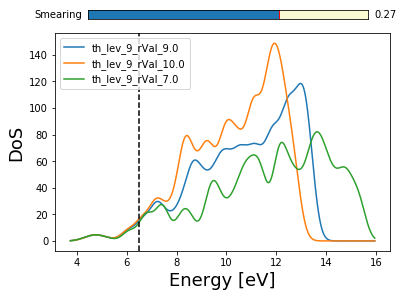

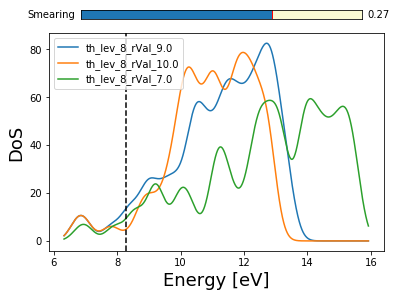

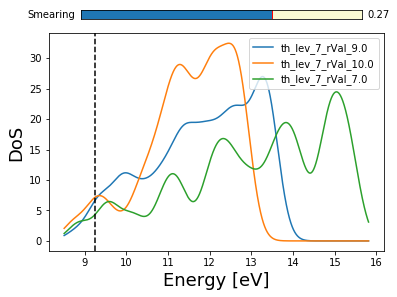

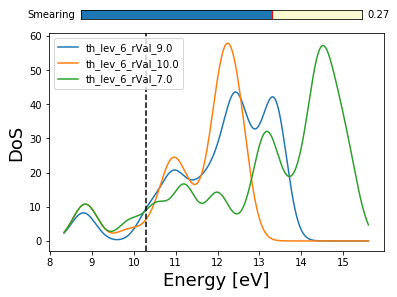

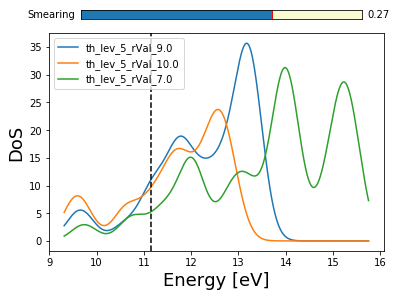

In [35]:
%matplotlib inline
levels = [9,8,7,6,5]
for l in levels:
    fe = HaeV*abs(LR.get_p_energy(C6H6[7.0]['logfile'],norbC6H6)[th_levels.index(l)])
    dos=D.DoS(fermi_level=fe)
    for rVal in C6H6_channels:
        eng = []
        for exc in C6H6_channels[rVal][l]:
            eng.append(exc[1])
        dos.append(energies=np.array([eng]),label='th_lev_'+str(l)+'_rVal_'+str(rVal))
    dos.plot(sigma=0.01*HaeV)

We repeat the calculation of dynamical polarizability separing the contributions due to excitations above and below threshold  

In [131]:
reload(LR)
C6H6_spectrum_bt,C6H6_spectrum_at = LR.collect_spectrum_bt_at(C6H6,C6H6_in_bt,C6H6_ind_at)

numpoint =  99  omegaMax (eV) =  13.5074761597
numpoint =  99  omegaMax (eV) =  13.5074761597
numpoint =  94  omegaMax (eV) =  12.8450322156
numpoint =  94  omegaMax (eV) =  12.8450322156
numpoint =  113  omegaMax (eV) =  15.4923605166
numpoint =  113  omegaMax (eV) =  15.4923605166


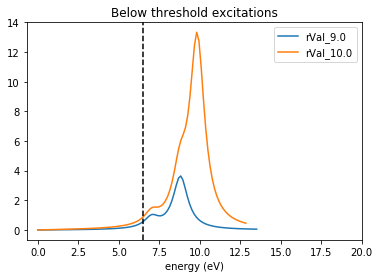

In [135]:
syst = C6H6_spectrum_bt
for rVal in [9.0,10.0]: #syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Below threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

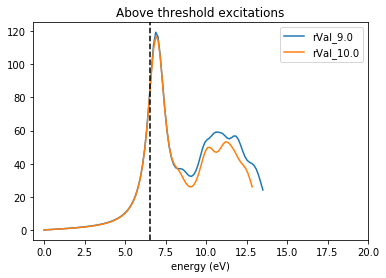

In [134]:
%matplotlib inline
syst = C6H6_spectrum_at
for rVal in [9.0,10.0]: #syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Above threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

This behavior is not completely clear since it seems that the localized sector of the excitations gives a box dependent contribution to the spectrum. On the contrary the the continuum sector gives a stable contribution to the main peak. This may be due to the fact the peak is very close to the threshold, so the collapse of the continuum may be already realized. Other possibility is a wrong interpretation of some of the excitations due to the degeneracies...

Convergence of the statical polarizability in function of the number of excitations

In [12]:
th_value = 5e-2 # best result for 5e-2
th_levels = [1,2,2,3,3,4,5,5,6,6,7,8,8,9,9]
reload(LR)
numExc = 6600
LR.collect_excitation_thr(C6H6,norbC6H6,numExc,th_levels,th_value)
C6H6_channels = LR.collect_channels(C6H6,norbC6H6,numExc,th_levels)
C6H6_ind_bt,C6H6_ind_at = LR.collect_index_bt_at(C6H6)

In [220]:
#C6H6_ind_bt

In [103]:
rVal = 10.0
print C6H6[rVal]['eigenproblems'][220]['alpha_xyz']
e2 = C6H6[rVal]['eigenproblems'][220]['eigenvalues']
f = C6H6[rVal]['eigenproblems'][220]['oscillator_strengths']
alp = LR.static_polarizabilities(e2,f)
print alp

[ 82.05694636  82.04679298  42.26547609]
[ 82.05694636  82.04679298  42.26547609]


In [104]:
ist = []
for exc in range(numExc):
    ist.append(2.0*f[exc][0]/e2[exc])

intIst = [0.0 for i in range(numExc)]

In [105]:
for ind,val in enumerate(ist):
    if ind > 0:
        intIst[ind] = intIst[ind-1]+val

In [106]:
e = HaeV*np.sqrt(e2[0:numExc])

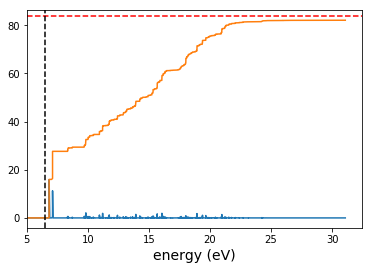

In [107]:
%matplotlib inline
plt.plot(e,1.0*np.array(ist))
plt.plot(e,np.array(intIst))
plt.axhline(y=C6H6_alpha_ref['alphaX'], color='r', linestyle='--')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[rVal]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.xlabel('energy (eV)',size = 14)
plt.xlim(xmin=5)
#plt.ylim(ymax=50)
#plt.ylim(ymax=90)
plt.show()

In [108]:
alphaBound = 0.0
for ind in C6H6_ind_bt[rVal]:
    alphaBound+=ist[ind]
alphaBound

2.0974229956264892

rmult = 7.0  alphaZ_Bound = 1.39 alphaX_Bound = 2.47

rmult = 9.0  alphaZ_Bound = 1.65 alphaX_Bound = 1.28e-5 

rmult = 10.0 alphaZ_Bound = 1.53 alphaX_Bound = 2.1


In [60]:
reload(LR)
dos=D.DoS(fermi_level=6.5)
nalpha = C6H6[rVal]['eigenproblems'].keys()
nalpha.sort()
nvirt = nalpha[-1]   
eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'])
dos.append(energies=np.array([eng]))
#dos.plot(sigma=0.002*HaeV)

omega, d = LR.extract_dos_val(dos,0.1)

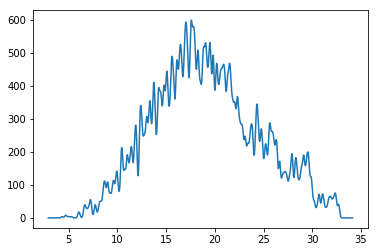

In [305]:
plt.plot(omega,d)

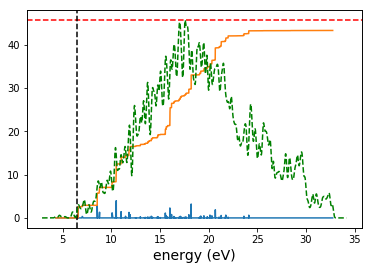

In [317]:
%matplotlib inline

fig, ax1 = plt.subplots()

ax1.set_xlabel('energy (eV)',size = 14)
#ax1.set_xlim(xmin=5)
ax1.plot(e,1.0*np.array(ist))
ax1.plot(e,np.array(intIst))

plt.axhline(y=C6H6_alpha_ref['alphaZ'], color='r', linestyle='--')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[rVal]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')

ax2 = ax1.twinx()
ax2.plot(omega,d,color='green',linestyle='--')
plt.yticks([])

plt.show()